# Import Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM, RepeatVector, TimeDistributed, Dropout

Using TensorFlow backend.


In [2]:
# To test and connect your work to your gpu if you have one
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Restrict TensorFlow to only use the fourth GPU
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [3]:
tf.version

<module 'tensorflow_core._api.v2.version' from 'C:\\Users\\Austin\\anaconda3\\envs\\deep_learning\\lib\\site-packages\\tensorflow_core\\_api\\v2\\version\\__init__.py'>

# Preprocessing

In [4]:
# Import the data
df = pd.read_csv('C:/Users/Austin/Documents/Jeff Kimmel/CO2.csv') # Change this directory to yours.
df.describe()

,co2
count,135099.000000
mean,688.833011
std,385.845573
min,369.000000
25%,429.000000
50%,483.000000
75%,852.000000
max,2626.000000


In [5]:
# Set date_time as index
df = df.set_index('ts')
# Show the data
df.head()

,co2
ts,
11/21/2016 0:47,708
11/21/2016 0:48,694
11/21/2016 0:49,693
11/21/2016 0:50,692
11/21/2016 0:51,690


In [6]:
df = df.astype('float32')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 135099 entries, 11/21/2016 0:47 to 3/28/2017 9:30
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   co2     135099 non-null  float32
dtypes: float32(1)
memory usage: 1.5+ MB


In [7]:
# normalise or scale data to be between 0 and 1
scaler = MinMaxScaler(feature_range=(0,1))
df1 = scaler.fit_transform(np.array(df).reshape(-1,1))
df1

array([[0.15019937],
       [0.14399646],
       [0.14355339],
       ...,
       [0.43597692],
       [0.4337616 ],
       [0.44040757]], dtype=float32)

In [8]:
# split the co2 dataset into train/test sets
# The first 9 datasets are truncated so as to give a proper split into 30mins-interval
def split_dataset(data):
    # split in the ratio 70-30
    train, test = data[9:int(len(df)*.7)], data[int(len(df)*.7):]
    # restructure into windows of 30min data
    train = np.array(np.split(train, len(train)/30))
    test = np.array(np.split(test, len(test)/30))
    return train, test

In [9]:
train, test = split_dataset(df1)
# validate train data
print(train.shape)
print(train[0, 0, 0], train[-1, -1, 0])
# validate test
print(test.shape)
print(test[0, 0, 0], test[-1, -1, 0])

(3152, 30, 1)
0.14355339 0.31103235
(1351, 30, 1)
0.3256535 0.44040757


In [10]:
# convert history into inputs and outputs
def to_supervised(train, n_input, n_out=30):
    # flatten data
    data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
    X, y = list(), list()
    in_start = 0
    # step over the entire history one time step at a time
    for _ in range(len(data)):
        # define the end of the input sequence
        in_end = in_start + n_input
        out_end = in_end + n_out
        # ensure we have enough data for this instance
        if out_end <= len(data):
            x_input = data[in_start:in_end, 0]
            x_input = x_input.reshape((len(x_input), 1))
            X.append(x_input)
            y.append(data[in_end:out_end, 0])
        # move along one time step
        in_start += 1
    return np.array(X), np.array(y)

In [11]:
# Quick check to test the function "to_supervised"
train_x, train_y = to_supervised(train, 30)
test_x, test_y = to_supervised(test, 30)
train_x.shape, train_y.shape

((94501, 30, 1), (94501, 30))

In [12]:
# I am transforming back to the original dataset so you see that y is actually 30mins ahead.
# X1 and y1 are just for this test. 
X1 = train_x.reshape(94501, 30) # reshape from 3D to 2D
X1 = scaler.inverse_transform(X1)
y1 = scaler.inverse_transform(train_y)
X1 # The first row of X1 starts from the 10th row in the dataset

array([[ 693.     ,  695.     ,  695.     , ...,  733.     ,  733.     ,
         735.     ],
       [ 695.     ,  695.     ,  696.     , ...,  733.     ,  735.     ,
         739.     ],
       [ 695.     ,  696.     ,  697.     , ...,  735.     ,  739.     ,
         741.99994],
       ...,
       [1076.0001 , 1067.     , 1099.     , ..., 1081.     , 1071.0001 ,
        1061.0001 ],
       [1067.     , 1099.     , 1089.     , ..., 1071.0001 , 1061.0001 ,
        1050.     ],
       [1099.     , 1089.     , 1073.0001 , ..., 1061.0001 , 1050.     ,
        1069.     ]], dtype=float32)

In [13]:
y1 # Each value is 30mins ahead of the first data of X1 

array([[ 739.     ,  741.99994,  743.     , ..., 1050.     , 1064.     ,
        1102.0001 ],
       [ 741.99994,  743.     ,  747.     , ..., 1064.     , 1102.0001 ,
        1113.     ],
       [ 743.     ,  747.     ,  756.     , ..., 1102.0001 , 1113.     ,
        1153.     ],
       ...,
       [1050.     , 1069.     , 1091.     , ..., 1056.     , 1056.     ,
        1062.     ],
       [1069.     , 1091.     , 1096.     , ..., 1056.     , 1062.     ,
        1067.     ],
       [1091.     , 1096.     , 1078.0001 , ..., 1062.     , 1067.     ,
        1071.0001 ]], dtype=float32)

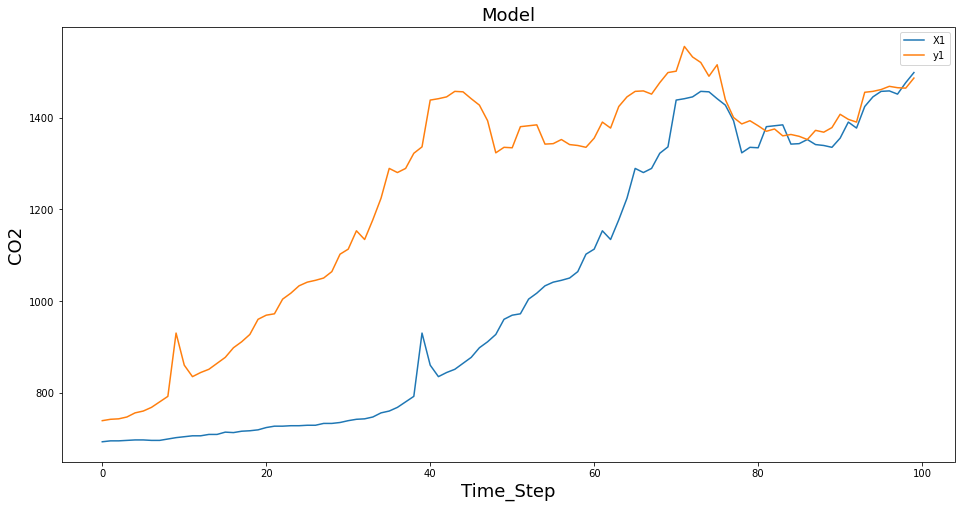

In [14]:
# As you can see the first X1 value 693 has a corresponding y1 value 739
# Check the dataset. The first 9 data in the CO2 excel sheet were truncated. 
# So start from the 10th data in the sheet which is 693. Now count, 30 from 693, you will get 739- the value of y1
# Here is a plot of X1 and y1 just for visualisation.

plt.figure(figsize=(16,8))
plt.title('Model', fontsize=18)
plt.xlabel('Time_Step', fontsize=18)
plt.ylabel('CO2', fontsize=18)
plt.plot(X1[:,0][:100]) # First 100 data in the first column.
plt.plot(y1[:,0][:100]) # First 100 data in the first column
plt.legend(['X1', 'y1'], loc='upper right')
plt.show()

# LSTM Model

In [15]:
# train the model
n_input = 30
train_x, train_y = to_supervised(train, n_input)
# define parameters
verbose, epochs, batch_size = 1, 10, 30
n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
# reshape output into [# LSTM Modelsamples, timesteps, features]
train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
# define model
model = Sequential()
model.add(LSTM(200, activation='relu', dropout=0.2, input_shape=(n_timesteps, n_features)))
model.add(RepeatVector(n_outputs))
model.add(LSTM(200, activation='relu', dropout=0.2, return_sequences=True))
model.add(TimeDistributed(Dense(100, activation='relu')))
model.add(TimeDistributed(Dense(1)))
model.compile(loss='mse', optimizer='adam')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 200)               161600    
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 30, 200)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 30, 200)           320800    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 30, 100)           20100     
_________________________________________________________________
time_distributed_2 (TimeDist (None, 30, 1)             101       
Total params: 502,601
Trainable params: 502,601
Non-trainable params: 0
_________________________________________________________________


In [44]:
# fit network
model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)

Epoch 1/10
94501/94501 [==============================] - 239s 3ms/step - loss: 0.0070
Epoch 2/10
94501/94501 [==============================] - 244s 3ms/step - loss: 0.0066 3
Epoch 3/10
94501/94501 [==============================] - 234s 2ms/step - loss: 0.0064
Epoch 4/10
94501/94501 [==============================] - 203s 2ms/step - loss: 0.0064
Epoch 5/10
94501/94501 [==============================] - 190s 2ms/step - loss: 0.0065
Epoch 6/10
94501/94501 [==============================] - 189s 2ms/step - loss: 0.0063
Epoch 7/10
94501/94501 [==============================] - 189s 2ms/step - loss: 0.0067
Epoch 8/10
94501/94501 [==============================] - 190s 2ms/step - loss: 0.0062
Epoch 9/10
94501/94501 [==============================] - 191s 2ms/step - loss: 0.0063 
Epoch 10/10
94501/94501 [==============================] - 191s 2ms/step - loss: 0.0063


In [16]:
from keras.models import load_model

# model.save('my_model.h5')  # creates a HDF5 file 'my_model.h5'
# del model - deletes the existing model

model = load_model('my_model.h5') # returns a compiled model identical to the previous one

In [17]:
# make a forecast
def forecast(model, history, n_input):
    # flatten data
    data = np.array(history)
    data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
    # retrieve last observations for input data
    input_x = data[-n_input:, 0]
    # reshape into [1, n_input, 1]
    input_x = input_x.reshape((1, len(input_x), 1))
    # forecast the next 30min
    yhat = model.predict(input_x, verbose=0)
    # we only want the vector forecast
    yhat = yhat[0]
    return yhat

In [18]:
# evaluate one or more 30min forecasts against expected values
def evaluate_forecasts(actual, predicted):
    scores = list()
    # calculate an RMSE score for each minute
    for i in range(actual.shape[1]):
        # calculate mse
        mse = mean_squared_error(actual[:, i], predicted[:, i])
        # calculate rmse
        rmse = sqrt(mse)
        # store
        scores.append(rmse)
    # calculate overall RMSE
    s = 0
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (actual[row, col] - predicted[row, col])**2
    score = sqrt(s / (actual.shape[0] * actual.shape[1]))
    return score, scores

In [19]:
# evaluate a single model
def evaluate_model(train, test, n_input):
    # fit model
    model = load_model('my_model.h5')
    # history is a list of 30min-interval data
    history = [x for x in train]
    # walk-forward validation over each 30min 
    predictions = list()
    for i in range(len(test)):
        # predict the 30min
        yhat_sequence = forecast(model, history, n_input)
        # store the predictions
        predictions.append(yhat_sequence)
        # get real observation and add to history for predicting the next 30min
        history.append(test[i, :])
    # evaluate predictions (minutes) for each 30min
    predictions = np.array(predictions)
    score, scores = evaluate_forecasts(test[:, :, 0], predictions)
    return score, scores

# summarize scores
def summarize_scores(name, score, scores):
    s_scores = ', '.join(['{:.1f}'.format(s) for s in scores])
    print('{}: [{:.3f}] {}'.format(name, score, s_scores))

lstm: [0.071] 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1


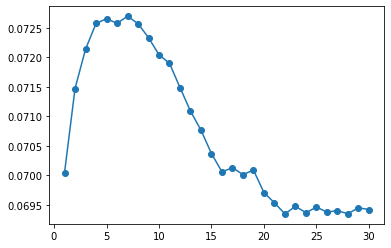

In [20]:
# evaluate model and get scores. The scores are approximately 0.1 but the actual values are as depicted in the graph.
n_input = 30
score, scores = evaluate_model(train, test, n_input)
# summarize scores
summarize_scores('lstm', score, scores)
# plot scores
time = [t for t in range(1,31)]
plt.plot(time, scores, marker='o', label='lstm')
plt.show()

In [28]:
test_y.shape

(40471, 30)

In [31]:
# Lets Do the prediction and check performance metrics
test_pred = model.predict(test_x) # test_pred is the prediction on test_x
test_pred1 = test_pred.reshape(40471, 30) 
test_y1 = test_y # test_y is the actual value of y 30 minutes ahead given x
test_x1 = test_x.reshape(40471, 30)
test_y1.shape

(40471, 30)

In [32]:
# Transform back to original form
test_x1 = scaler.inverse_transform(test_x1)
test_y1 = scaler.inverse_transform(test_y1)
test_pred1 = scaler.inverse_transform(test_pred1)

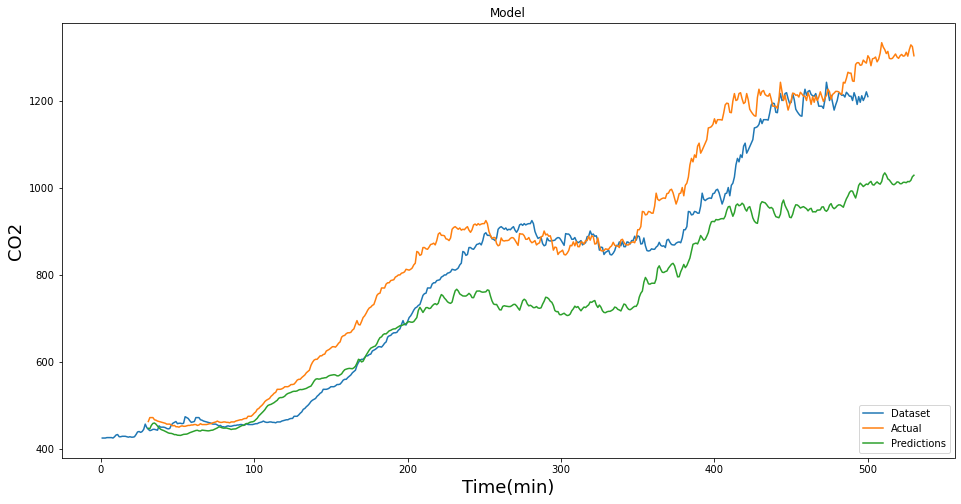

In [66]:
# Plot test vs predictions 
time = np.arange(1,501) # 30 minute data needed for prediction
time_pred = np.arange(31,531)
#time = [t for t in range(1,1001)]
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Time(min)', fontsize=18)
plt.ylabel('CO2', fontsize=18)
plt.plot(time, test_x1[-530:-30, 0])
plt.plot(time_pred, test_y1[-500:, 0])
plt.plot(time_pred, test_pred1[-500:, 0])
plt.legend(['Dataset', 'Actual', 'Predictions'], loc='lower right')
plt.show()

In [65]:
test_x1[-530:-30, 0].shape

(500,)

In [67]:
# This is how the predicted values compare with the actual test result for 30 minutes data. 
valid = pd.DataFrame({'x_Dataset':test_x1[-530:-30, 0], 'Actual':test_y1[-500:, 0], 'Predicted':test_pred1[-500:, 0]})
valid

,x_Dataset,Actual,Predicted
0,425.0,463.000000,447.339233
1,425.0,472.000000,446.436981
2,425.0,472.000000,454.209259
3,426.0,472.000000,458.603729
4,426.0,466.999969,459.567352
...,...,...,...
495,1212.0,1303.000122,1014.933105
496,1201.0,1318.000000,1014.199646
497,1209.0,1329.000000,1017.519409
498,1221.0,1325.000000,1025.810791
